In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd
import random
import math
import time

## Neural Network using Stochastic Gradient Descent

In [9]:
class Neural_Network():
    def __init__(self, NN_structure, alpha, max_iter):
        self.NN_structure = NN_structure
        self.n_layers = len(NN_structure)
        self.alpha = alpha
        self.max_iter = max_iter
    
    # Defind some types of activation functions and its derivatives:
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self,x):
        return self.sigmoid(x)*(1-self.sigmoid(x))
    
    def linear(self,x):
        return x
    
    def d_linear(self,x):
        return 1

    def relu(self,x):
        return np.maximum(0,x)

    def d_relu(self,x):
        dx = np.where(x <= 0, 0, 1)
        return dx

    def tanh(self,x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    def d_tanh(self,x):
        return 1 - self.tanh(x)**2
    
    
    # Initialize weights:
    def init_weights(self, seed):
        np.random.seed(seed)
        self.theta_ = {}
        for L in range(1, self.n_layers):
#             self.theta_['Layer' + str(L+1)] = np.ones((self.NN_structure[L]['n_neurons'], \
#                                                         self.NN_structure[L-1]['n_neurons'] + 1)) * 0.2
            self.theta_['Layer' + str(L+1)] = np.random.randn(self.NN_structure[L]['n_neurons'], \
                                                        self.NN_structure[L-1]['n_neurons'] + 1) * 0.1
        return self.theta_
    

    def add_bias(self, Xi):
        Xi = np.concatenate(([1], Xi))
        return Xi
    
    def copy_column(self, Xi, n):
        Ai = Xi.T
        for _ in range(n-1):
            Ai = np.concatenate((Ai, Xi.T), axis = 1)
        return Ai
    
    def forward_propagation(self, Xi):
        self.z_ = {}
        self.a_ = {}
        self.z_['2'] = np.dot(self.theta_['Layer2'], self.add_bias(Xi).T)
        self.a_['2'] = eval('self.'+self.NN_structure[1]['activ_func'])(self.z_['2'])
        
        for L in range (2, self.n_layers):
            self.a_[str(L)] = self.add_bias(self.a_[str(L)])
            self.z_[str(L+1)] = np.dot(self.theta_['Layer'+str(L+1)],self.a_[str(L)])
            self.a_[str(L+1)] = eval('self.'+self.NN_structure[L]['activ_func'])(self.z_[str(L+1)])
        return self
            
    def fit(self, X, y):    # including training and validation
        self.init_weights(seed = 10)
        self.costs = []
        self.R_sq_record = []
        n_train = math.ceil(0.9 * X.shape[0])
        n_validate = X.shape[0] - n_train
        
        X_train = X[0 : n_train]
        y_train = y[0 : n_train]
        X_validate = X[n_train : X.shape[0]]
        y_validate = y[n_train : X.shape[0]]
        
        self.n_iter = 0
        for _ in range(self.max_iter):
            cost = 0
            for i in range(X_train.shape[0]):
                self.delta = {}
                self.update = {}

                self.forward_propagation(X_train[i])
                self.delta[str(self.n_layers)] = self.a_[str(self.n_layers)] - y_train[i]
                delta_copy = self.copy_column(np.array([self.delta[str(self.n_layers)]]), \
                                              self.NN_structure[self.n_layers-2]['n_neurons'] + 1)

                self.update[str(self.n_layers)] = np.multiply(self.a_[str(self.n_layers-1)], delta_copy)

                cost += ((self.a_[str(self.n_layers)]-y_train[i])**2/2/X_train.shape[0]).sum()
                
                self.a_['1'] = self.add_bias(X_train[i])
                for L in range(self.n_layers-1, 1, -1):
                    theta_back = np.delete(self.theta_['Layer'+str(L+1)], 0, 1)
                    self.delta[str(L)] = np.multiply(np.dot(theta_back.T, self.delta[str(L+1)]), \
                        eval('self.d_' + self.NN_structure[L-1]['activ_func'])(self.z_[str(L)]))
                    delta_copy = self.copy_column(np.array([self.delta[str(L)]]), \
                                              self.NN_structure[L-2]['n_neurons'] + 1)
                    self.update[str(L)] = np.multiply(self.a_[str(L-1)], delta_copy)

                for L in range(2, self.n_layers+1):
#                     if self.optimizer == 'SGD':
                    self.theta_['Layer'+str(L)] -= self.alpha * self.update[str(L)]
#                     if self.optimizer == 'ADAM':
                        
            
            sum_theta_sq = 0
            for L in range(2, self.n_layers + 1):
                sum_theta_sq += np.square(self.theta_['Layer'+str(L)]).sum()
            
            # Validation step:
            SS_res = 0
            for j in range(X_validate.shape[0]):
                self.forward_propagation(X_validate[j])
                error_each_sample = ((self.a_[str(self.n_layers)] - y_validate[j])**2).sum()
                SS_res += error_each_sample
            y_bar = y_validate.mean(0)
            SS_total = ((y_validate - y_bar)**2).sum()
            R_sq = (1 - SS_res/ SS_total)
            if R_sq >= 0.9:
                break
            self.n_iter += 1
            self.R_sq_record.append(R_sq)
            self.costs.append(cost)
        return self

## Import Data & Data Processing

In [10]:
input_data = pd.read_excel('Input_AHM.xlsx')
target = pd.read_excel('Output_AHM.xlsx')
field_data = pd.read_excel('Field_data.xlsx')
y_merge = np.concatenate((target, field_data), axis = 0)
y_merge = np.log(y_merge)

np.random.seed(101)
input_data, target = shuffle(input_data, target)

n_train = math.ceil(0.90 * input_data.shape[0])           # 90% data for training and validation
n_test = input_data.shape[0] - n_train                    # the rest for blind testing

X = input_data.values
y = target.values
y = np.log(y)
field_data = field_data.values

X_1 = X.min(axis = 0)
X_2 = X.max(axis = 0)
for i in range(len(X_1)):
    print('Min: ', X_1[i], 'Max: ', X_2[i])

def normalize(X):
    A = X.copy()
    mean = X.mean(axis = 0)
    diff = X.max(axis = 0) - X.min(axis = 0)
    for j in range(0, X.shape[1]):  
        A[:,j] = (X[:,j] - mean[j]) / diff[j]
    return A

X_norm = normalize(X)
y_norm = normalize(y)

# Define ranges of parameters:
bound_min = X_norm.min(axis = 0)
bound_max = X_norm.max(axis = 0)
diff = np.fabs(bound_max - bound_min)
bounds = []
for i in range(bound_min.shape[0]):
    bounds.append((bound_min[i], bound_max[i]))

# Normalize the field oil production:
y_merge_norm = normalize(y_merge)
field_data_norm = y_merge_norm[-1]

# Split the dataset:
X_train = X_norm[0 : n_train]
y_train = y_norm[0 : n_train]
X_test = X_norm[n_train : input_data.shape[0]]
y_test = y_norm[n_train : input_data.shape[0]]

Min:  21.43146221 Max:  149.9332255
Min:  0.051028982 Max:  0.348972798
Min:  0.050216212 Max:  0.349233046
Min:  0.100115801 Max:  0.298431349
Min:  0.00012343 Max:  0.09947186
Min:  1.132956938 Max:  6.961200971
Min:  1.109156163 Max:  6.985529649
Min:  1.15617542 Max:  6.997305555
Min:  1.091106906 Max:  6.918394163
Min:  0.203403941 Max:  0.897131777
Min:  0.50351302 Max:  0.999726859
Min:  0.801704905 Max:  0.997874691
Min:  0.005688953 Max:  0.099497447
Min:  0.138182724 Max:  7.954185614
Min:  0.105462389 Max:  7.919723408


## Regression with Neural Network

In [4]:
# Neural Network Regression:
NN_structure = [{'n_neurons' : 15, 'activ_func' : 'none'},   
                {'n_neurons' : 45, 'activ_func' : 'tanh'},
                {'n_neurons' : 80, 'activ_func' : 'tanh'},
                {'n_neurons' : 50, 'activ_func' : 'linear'}]       

ANN = Neural_Network(NN_structure, alpha = 0.008, max_iter = 700) 

ANN.fit(X_train, y_train)

theta = ANN.theta_

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def linear(x):
    return x

def relu(x):
    return np.maximum(0,x)

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def forward_propagation(Xi):
    z_ = {}
    a_ = {}
    z_['2'] = np.dot(ANN.theta_['Layer2'], ANN.add_bias(Xi).T)
    a_['2'] = eval(ANN.NN_structure[1]['activ_func'])(z_['2'])

    for L in range (2, ANN.n_layers):
        a_[str(L)] = ANN.add_bias(a_[str(L)])
        z_[str(L+1)] = np.dot(ANN.theta_['Layer'+str(L+1)], a_[str(L)])
        a_[str(L+1)] = eval(ANN.NN_structure[L]['activ_func'])(z_[str(L+1)])
    return a_[str(ANN.n_layers)]    # return output of the forward calculation

## Sampling Technique: Latin Hypercube using Uniform Distribution
## Optimizer: Particle Swarm

In [5]:
class Latin_Hypercube_Uniform():
    def __init__(self, bounds, n_particles):
        self.bounds = bounds
        self.n_particles = n_particles

    def init_population(self):
        n = self.n_particles
        dimension = len(bounds)
        bound_min, bound_max = np.transpose(bounds)
    
        lower_bounds = np.array([])
        upper_bounds = np.array([])
        for i in range(dimension):
            lower_bounds = np.array(np.concatenate((lower_bounds, np.arange(bound_min[i], bound_max[i], (bound_max[i]-bound_min[i])/n)), axis = 0))
            upper_bounds = np.array(np.concatenate((upper_bounds, np.arange(bound_min[i]+(bound_max[i]-bound_min[i])/n, \
                                                                bound_max[i]+(bound_max[i]-bound_min[i])/n/2, (bound_max[i]-bound_min[i])/n)), axis = 0))
        aa = lower_bounds.shape[0]
        lower_bounds = lower_bounds.reshape(dimension, int(aa/dimension))
        upper_bounds = upper_bounds.reshape(dimension, int(aa/dimension))

        population = np.zeros((dimension, n))
        for i in range(len(lower_bounds)):
            population[i] = np.random.uniform(low=lower_bounds[i], high=upper_bounds[i], size=[1, n])[0]
        population = population.T

        for k in range(population.shape[1]):
            np.random.shuffle(population[:, k])
        return population

class ANN_forward():
    def __init__(self, NN_structure, theta):
        self.NN_structure = NN_structure
        self.theta = theta
        self.n_layers = len(NN_structure)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def linear(self, x):
        return x

    def relu(self, x):
        return np.maximum(0,x)

    def tanh(self, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    
    def add_bias(self, Xi):
        Xi = np.concatenate(([1], Xi))
        return Xi
    
    def forward_propagation(self, Xi):
        z_ = {}
        a_ = {}
        z_['2'] = np.dot(theta['Layer2'], self.add_bias(Xi).T)
        a_['2'] = eval(self.NN_structure[1]['activ_func'])(z_['2'])

        for L in range (2, self.n_layers):
            a_[str(L)] = self.add_bias(a_[str(L)])
            z_[str(L+1)] = np.dot(theta['Layer'+str(L+1)], a_[str(L)])
            a_[str(L+1)] = eval(self.NN_structure[L]['activ_func'])(z_[str(L+1)])
        return a_[str(self.n_layers)]    # return output of the forward calculation
    
class PSO():
    def __init__(self, bounds, n_particles, target, tolerance, max_iter):
        self.dim = len(bounds)
        self.n_particles = n_particles
        self.bounds = bounds
        self.bound_min, self.bound_max = np.transpose(self.bounds)
        self.target = target
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.position = Latin_Hypercube_Uniform(self.bounds, self.n_particles).init_population()
        self.velocity = np.zeros((self.n_particles, self.dim))
        self.pbest_position = self.position
        self.pbest_value = np.ones(self.n_particles) * float('inf')
        self.gbest_position = []
        for i in range(self.dim):
            self.gbest_position.append(np.random.uniform(self.bound_min[i], self.bound_max[i]))
        self.gbest_value = float('inf')
    
    def obj_function(self, position):
        global NN_structure, theta, field_data_norm
        ANN = ANN_forward(NN_structure, theta)
        output = ANN.forward_propagation(position)
        return ((field_data_norm - output)**2).sum()/2
        
    def find_pbest(self):
        for i in range(self.n_particles):
            if self.obj_function(self.position[i]) < self.pbest_value[i]:
                self.pbest_position[i] = self.position[i]
                self.pbest_value[i] = self.obj_function(self.position[i])
                
    def find_gbest(self):
        for i in range(self.n_particles):
            if self.obj_function(self.position[i]) < self.gbest_value:
                self.gbest_position = self.position[i]
                self.gbest_value = self.obj_function(self.position[i])
                
    def move_particle(self):
        global W, c1, c2
        r1 = np.random.random()
        r2 = np.random.random()
        for i in range(n_particles):
            self.velocity[i] = W*self.velocity[i] + c1*r1*(self.pbest_position[i] - self.position[i]) \
                                                    + c2*r2*(self.gbest_position - self.position[i])
            self.position[i] = self.position[i] + self.velocity[i]
            
    def optimization(self):
        self.n_iter = 0
        self.gbest_vector = []
        self.error = []
        while self.n_iter < self.max_iter:
            self.find_pbest()
            self.find_gbest()
            if abs(self.gbest_value - self.target) <= self.tolerance:
                break
            self.move_particle()
            self.n_iter += 1
            self.gbest_vector.append(self.gbest_value)

## Run PSO and denormalize the results

The best solution is:  [1.03165426e+02 2.20941098e-01 2.90727878e-01 1.68565718e-01
 3.97282414e-02 5.05789466e+00 4.29285125e+00 5.16937903e+00
 4.93482449e+00 4.27352472e-01 7.10121082e-01 9.21214173e-01
 7.34892897e-02 2.25136074e+00 3.01111068e+00] 

Number of iterations = 200
Objective function = 0.09302580083404316


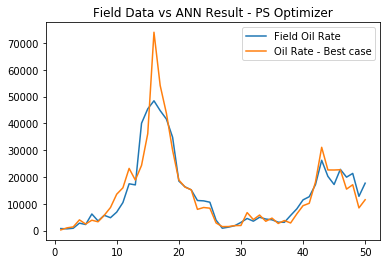

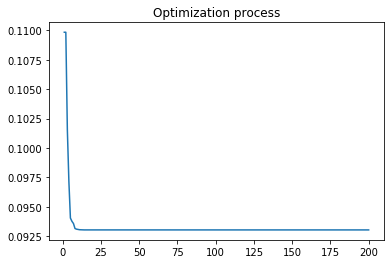

[0.10984742084670338, 0.10984742084670338, 0.10155093766327766, 0.09714775146752298, 0.09403535005568818, 0.09375713518602534, 0.09356872378097121, 0.09314350153671057, 0.09309031890057948, 0.09306324818856279, 0.0930422745741057, 0.09303565669479619, 0.09302797050203974, 0.0930267030903246, 0.09302658164385554, 0.09302657075904328, 0.09302656968315952, 0.09302656957569716, 0.09302595965127526, 0.09302591184250025, 0.09302584277547682, 0.09302581438239105, 0.09302581014443623, 0.0930258010013186, 0.09302580085177342, 0.09302580084518673, 0.09302580084461169, 0.09302580083413789, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.09302580083404316, 0.0930258008340

In [14]:
# Hyperparameters:
n_particles = 200
W = 0.1
c1 = 0.32
c2 = 0.56
target = 0
tolerance = 1e-2
max_iter = 200


# __main()__:
search_space = PSO(bounds, n_particles, target, tolerance, max_iter)
search_space.optimization()
output = forward_propagation(search_space.gbest_position)

# Denormalize the results:
mean_X = X.mean(axis = 0)
mean_y = y.mean(axis = 0)
diff_X = X.max(axis = 0) - X.min(axis = 0)
diff_y = y.max(axis = 0) - y.min(axis = 0)

def denormalize(X_norm, mean_X, diff_X):
    X_denorm = X_norm.copy()
    for j in range(X_norm.shape[0]):  
        X_denorm[j] = X_norm[j] * diff_X[j] + mean_X[j]
    return X_denorm

y_ANN = denormalize(output, mean_y, diff_y)
y_ANN = np.exp(y_ANN)

# Denormalize the best input set:
best_solution = denormalize(search_space.gbest_position, mean_X, diff_X)

print('The best solution is: ', best_solution, '\n\nNumber of iterations = {}'.format(search_space.n_iter))
print('Objective function =', search_space.gbest_value)


# Visualization:
plt.plot(range(1, 51), field_data[0])
plt.plot(range(1, 51), y_ANN)
plt.title('Field Data vs ANN Result - PS Optimizer')
plt.legend(['Field Oil Rate','Oil Rate - Best case'])
plt.show()

error = ((field_data[0] - y_ANN)**2).sum()


# Plot objective function vs. iteration:
plt.plot(range(1, search_space.n_iter + 1), search_space.gbest_vector)
plt.title('Optimization process')
plt.show()

print(search_space.gbest_vector)

In [7]:
# Possible solution:
solution_1 = [1.29084008e+02, 1.33045386e-01, 9.85414190e-02, 1.63185267e-01, \
 8.31680884e-02, 2.95725818e+00, 5.65002893e+00, 2.42327903e+00, \
 3.76551484e+00, 5.29106490e-01, 6.52705404e-01, 9.29428273e-01, \
 4.67545351e-02, 2.38800394e+00, 1.55040346e+00]     #obj_func = 0.16323341468981056

[1.14356085e+02 2.20038277e-01 1.90035999e-01 2.14094022e-01
 6.95366228e-02 2.61139396e+00 4.60154990e+00 2.37793787e+00
 3.48537813e+00 2.87813469e-01 6.65544700e-01 9.31788202e-01
 4.57005317e-02 1.81607595e+00 2.45870728e+00]    # obj = 0.14768403850063297

[1.32034298e+02 2.20997309e-01 1.01074821e-01 1.74356945e-01
 8.74247133e-02 3.20741601e+00 3.50433061e+00 2.73284808e+00
 5.17546131e+00 3.53761772e-01 6.58862408e-01 9.18143021e-01
 4.99220747e-02 2.45765094e+00 1.77543522e+00] # obj = 0.13599660777332975

SyntaxError: invalid syntax (<ipython-input-7-3b6293ecead4>, line 7)